In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from skzeros._AAA import AAA, poles_residues, zeros
from skzeros._domain import Rectangle

plt.style.use("style.mplstyle")

In [ ]:
@np.vectorize
def cauchy_integral_derivative(f, z, r=1, rtol=1e-15):
    def integrand(t):
        return np.exp(-t) * f(z + r * np.exp(t))

    m = 2
    s = integrand(2j * np.pi * np.arange(1, m + 1) / m)
    val1 = np.mean(s) / r
    err1 = np.nan
    while m < 1e6:
        m *= 2
        s = np.concatenate((s, integrand(2j * np.pi * np.arange(1, m + 1, step=2) / m)))
        val = np.mean(s) / r
        kappa = np.mean(np.abs(s)) / np.abs(val)
        err0 = np.abs(val - val1) / np.abs(val)
        err = (err0 / err1) ** 2 * err0
        if err <= kappa * rtol:
            return val
        val1 = val
        err1 = err0
    return np.nan

In [9]:
d = Rectangle(0, complex(1, 1))

rng = np.random.default_rng(123456)
f_zero_error = []
log_deriv_zero_error = []
log_deriv_AAA_zero_error = []
orders = [1, 2, 4, 6]

for order in orders:
    f_zero_error_tmp = []
    log_deriv_zero_error_tmp = []
    log_deriv_AAA_zero_error_tmp = []
    for _ in tqdm(range(1000)):
        # generate random zero
        zero = complex(rng.uniform(), rng.uniform())

        def f(z, order=order, zero=zero):
            return np.exp(z) * (z - zero) ** order

        def f_z(z, order=order, zero=zero):
            return (order * (z - zero) ** (order - 1) + (z - zero) ** order) * np.exp(z)

        res_f = AAA(f, d)
        res_log_deriv = AAA(lambda z: f_z(z) / f(z), d)

        f_zero_error_tmp.append(np.min(np.abs(zeros(*res_f) - zero)))
        log_deriv_zero_error_tmp.append(
            np.min(np.abs(poles_residues(*res_log_deriv) - zero))
        )

        res_log_deriv_AAA = AAA(
            lambda z: cauchy_integral_derivative(f, z, r=1e-2) / f(z), d, rtol=1e-12
        )
        log_deriv_AAA_zero_error_tmp.append(
            np.min(np.abs(poles_residues(*res_log_deriv_AAA) - zero))
        )

    f_zero_error.append(f_zero_error_tmp)
    log_deriv_zero_error.append(log_deriv_zero_error_tmp)
    log_deriv_AAA_zero_error.append(log_deriv_AAA_zero_error_tmp)

100%|██████████| 1000/1000 [00:08<00:00, 120.98it/s]


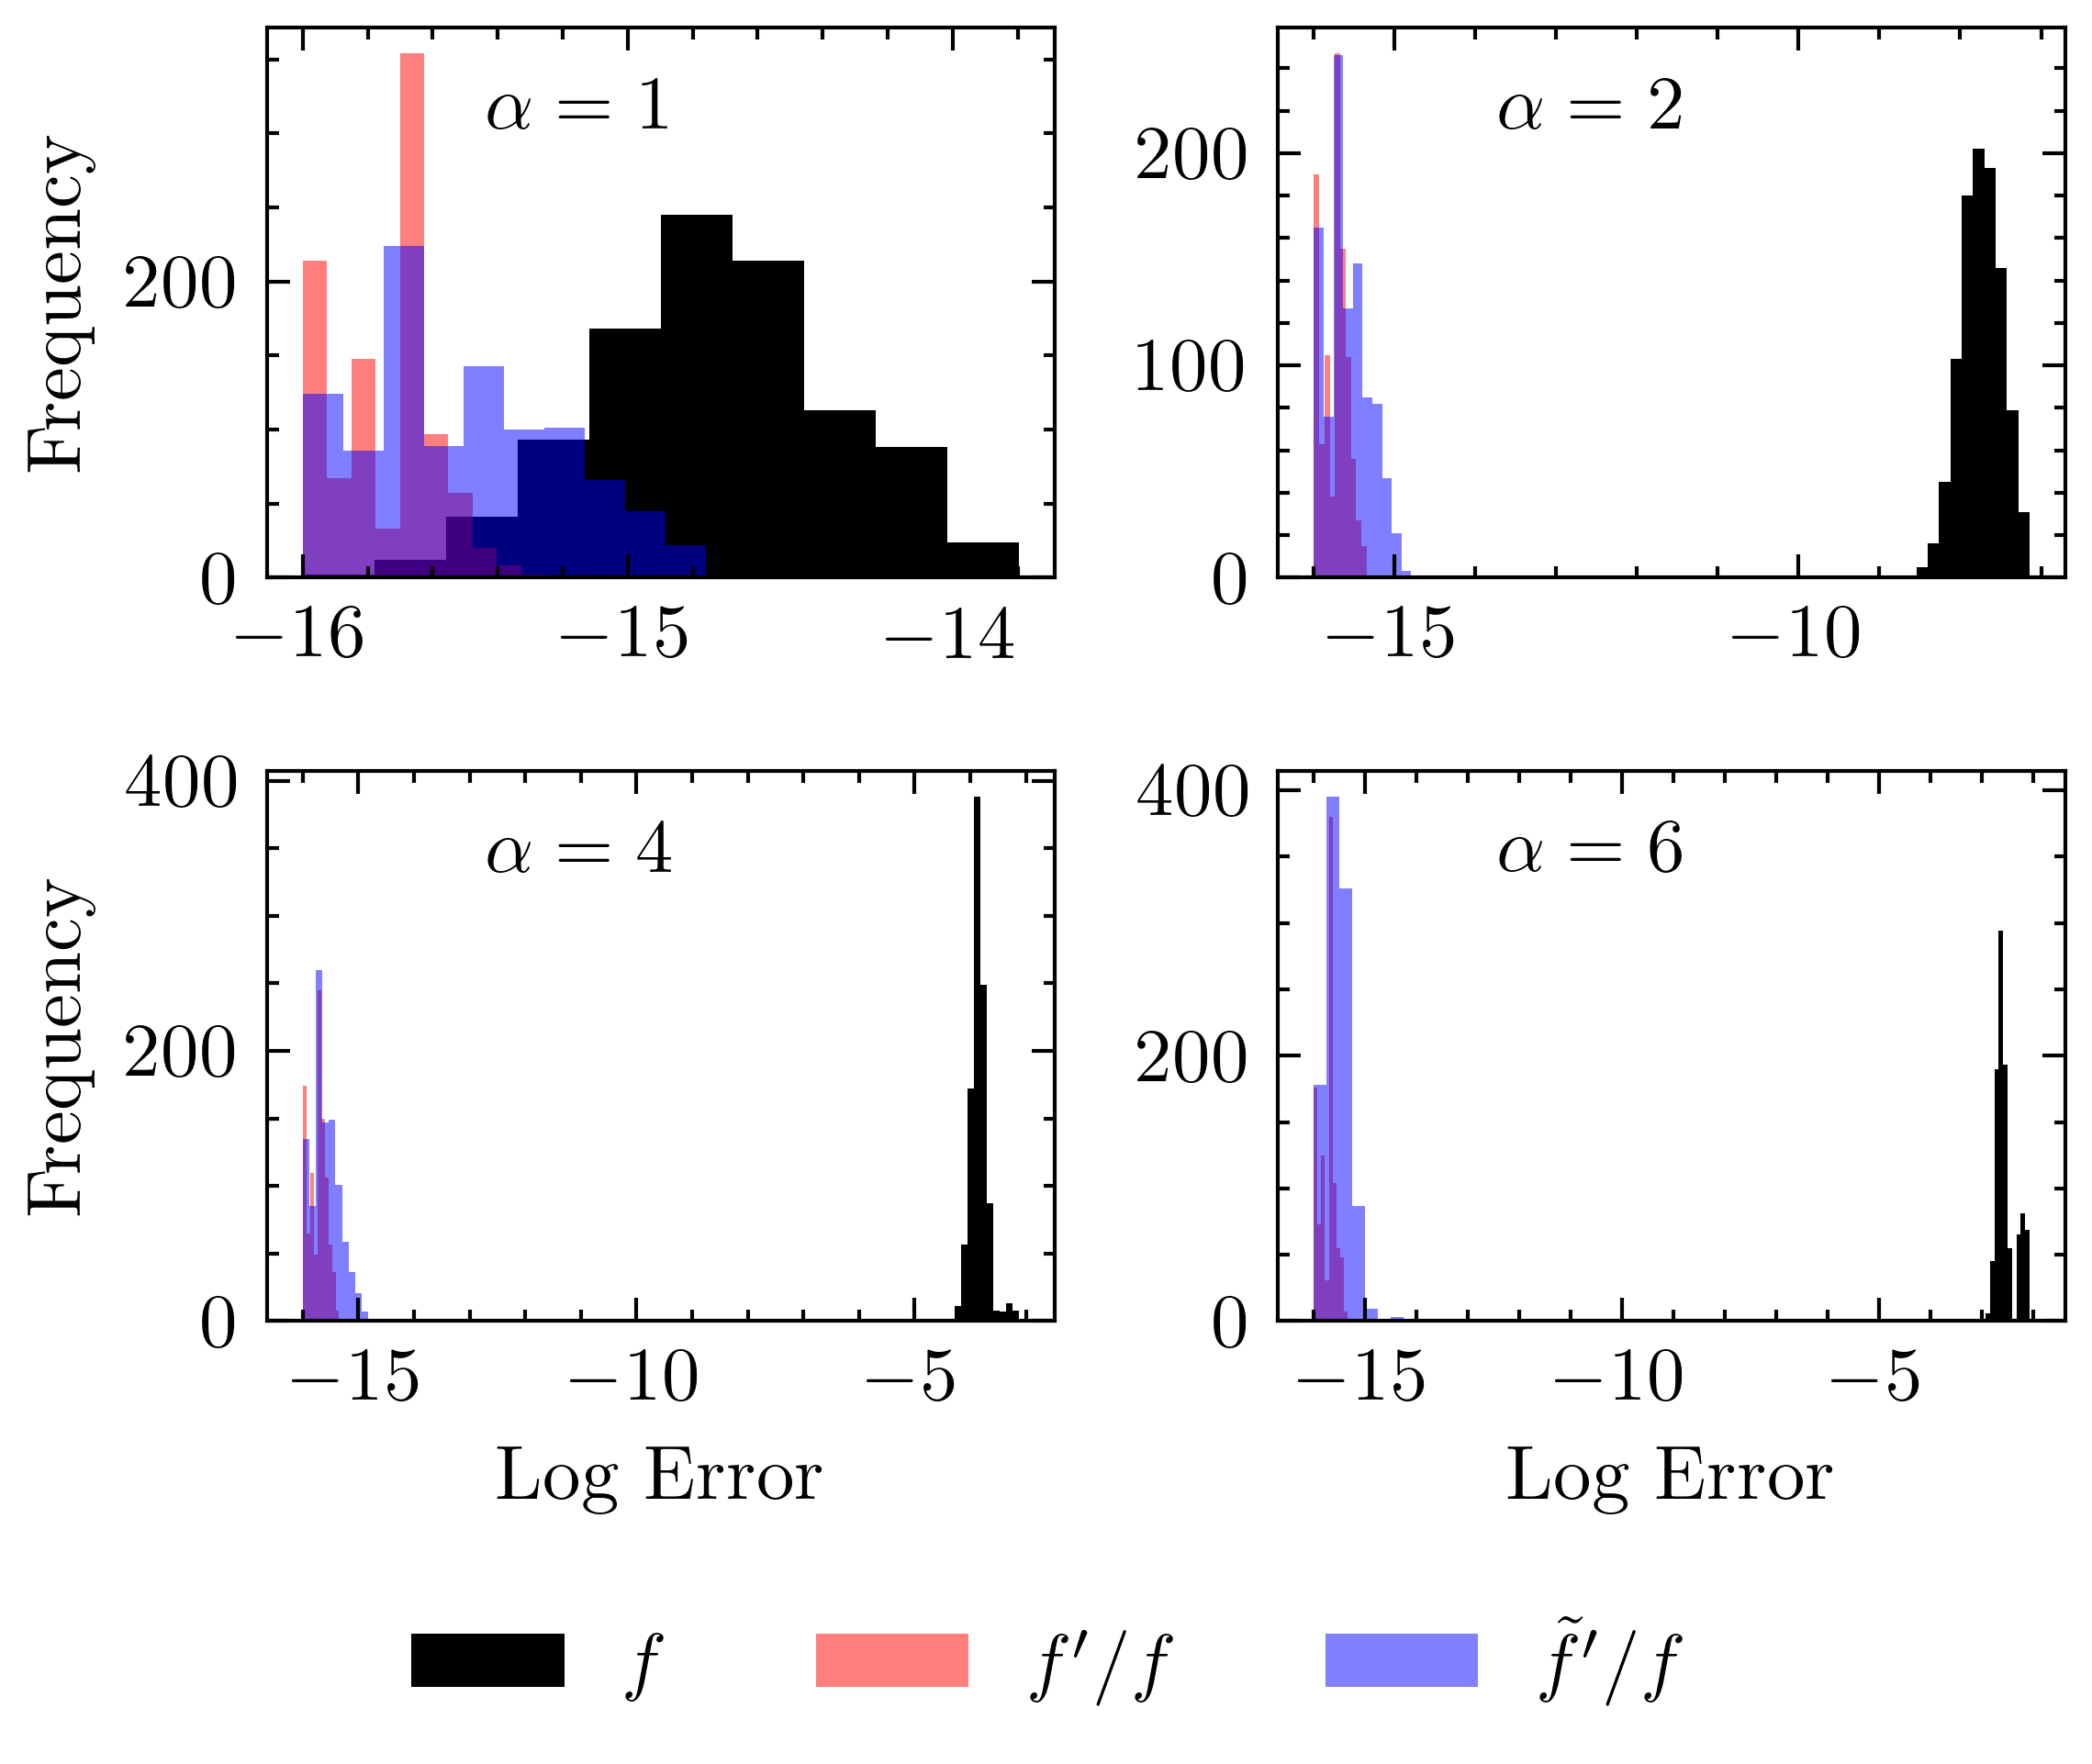

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 3), layout="tight")
for i, (ax, order) in enumerate(zip(axs.ravel(), orders, strict=False)):
    ax.hist(np.log10(np.asarray(f_zero_error[i]) + 1e-16), label="$f$")
    ax.hist(
        np.log10(np.asarray(log_deriv_zero_error[i]) + 1e-16),
        label=r"$f^\prime/f$",
        alpha=0.5,
    )
    ax.hist(
        np.log10(np.asarray(log_deriv_AAA_zero_error[i]) + 1e-16),
        label=r"$\tilde{f}^\prime/f$",
        alpha=0.5,
    )
    if i > 1:
        ax.set_xlabel("Log Error")
    if i % 2 == 0:
        ax.set_ylabel("Frequency")
    ax.text(
        0.4,
        0.85,
        rf"$\alpha={order}$",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.03),
    fancybox=True,
    shadow=True,
    ncol=4,
    fontsize=10,
)
plt.tight_layout()
plt.savefig("figures/log_deriv_zero_finding_accuracy.pdf")